# Titanic - Short/Fast approach

**Methodology:**
The goal of this attempt is to get relatively quick to the most valuable variables and identify a simple model. Therefore, we need to get a basic understanding of the data, without getting to deep into it or feature engineering.

Then, based on the results, we can try to identify ideas for further improvements in following attempts with 'deeper' analytics.    

Basic concept:  
1. Step: Import modules / load data
2. Step: Short EDA & delete the "poor" variables
3. Step: Identify variables most correlating with target variable
4. Step: Train models on best variables 
5. Step: Discussion of results

### 1. Step: Import modules / load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#sns.set_style('twilight')
#sns.color_palette(palette='Blues')
#plt.set_cmap('Blues')
sns.set_theme(style='darkgrid', palette='Set1')
cmap = 'BrBG'
import warnings
warnings.filterwarnings('ignore')

In [2]:
# little helper for later to show prediction table and accuracy
def show_table_acc(input):
    cm_df = pd.DataFrame(input)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0:'Actual 0',1:'Actual 1'})
    cm= np.array(cm_df)
    accuracy_train = (cm[0,0]+cm[1,1])/cm.sum()
    print(cm_df)
    print('Accuracy: ',accuracy_train.round(2))
    

In [136]:
train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')
submission_sample = pd.read_csv(r'gender_submission.csv')

### 2. Step: Short EDA & delete the "poor" variables

In [4]:
train.head()
#test.head()
#submission_sample.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


INFO: The target variable is *Survived*. 1 = 'Survived'; 0 = 'Not Survived' 

In [5]:
target = 'Survived'

In [6]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

INFO: 12 variables (including the PassengerID and the target variable)

In [7]:
columns= train.columns.tolist()
columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [8]:
for column in columns:
    try:
        print(column + ' (Train/Test): '+ 
          str(round(train[column].isnull().sum()/len(train[column])*100,2))+'%'+'/'+
          str(round(test[column].isnull().sum()/len(test[column])*100,2))+'%')
    except:
        pass

PassengerId (Train/Test): 0.0%/0.0%
Pclass (Train/Test): 0.0%/0.0%
Name (Train/Test): 0.0%/0.0%
Sex (Train/Test): 0.0%/0.0%
Age (Train/Test): 19.87%/20.57%
SibSp (Train/Test): 0.0%/0.0%
Parch (Train/Test): 0.0%/0.0%
Ticket (Train/Test): 0.0%/0.0%
Fare (Train/Test): 0.0%/0.24%
Cabin (Train/Test): 77.1%/78.23%
Embarked (Train/Test): 0.22%/0.0%


INFO:  
**Cabin** has ~ 78% missing values in both datasets and will be deleted  
**Age** has ~20% missing values in both datasets needs to be filled up (later to not confuse rest of the EDA)  

In [9]:
columns.remove('Cabin')

**Size of dataframes:**

In [10]:
print('Train: ' + str(train.shape))
print('Test: ' + str(test.shape))

Train: (891, 12)
Test: (418, 11)


INFO:  
891 lines in the train set and 418 in the test set.  
11 features to choose from (+1 Target Variable)

**Variable Types:**

In [11]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Numerical:  
    - Age  
    - SibSp  
    - Parch  
    - Fare  
    
Categorical:  
    - Pclass  
    - Sex  
    - Ticket  
    - Cabin   
    - Name  
    - Embarked     
    

**No. of values per feature:**

In [12]:
for column in columns:
    print(column + ': ' + str(train[column].nunique()))

PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 88
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Embarked: 3


Info:  
For this approach, we ignore Ticket, Name and PassengerId, as they are catgorical with too many values

In [13]:
columns.remove('Ticket')
columns.remove('Name')
columns.remove('PassengerId')
columns

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [14]:
train_c = train[columns]

### 3. Step: Identify variables most correlating with target variable

Info:  
As it is a binary variable, we encode the categorical variable *Sex* to use it in the correlation analysis

In [15]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
train_encoded = train_c.copy()
train_encoded['Sex'] = label.fit_transform(train_c['Sex'])

<AxesSubplot:>

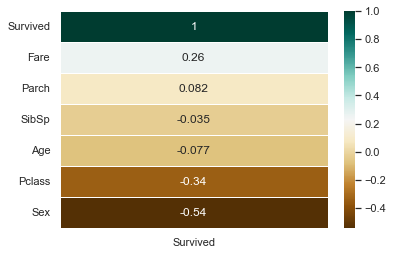

In [16]:
sns.heatmap(train_encoded.corr()[['Survived']].sort_values(by='Survived',ascending=False),cmap = cmap,annot = True,linewidths=.5)

INFO:  
From the correlation perspective the features **Sex**, **Pclass** and **Fare** seems to be the best candidate.  
Of course, the other variables could have a low correlation due to moderating effects we will not analyze in this approach.

#### Analysis of Top-3 Features:

**1.Feature: Sex**

<AxesSubplot:xlabel='Survived', ylabel='count'>

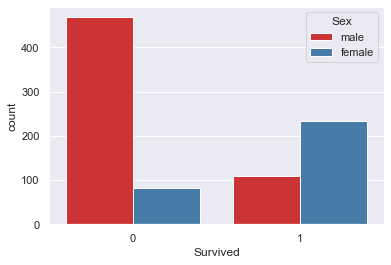

In [17]:
sns.countplot(data=train_c, x='Survived', hue='Sex')

In [18]:
print('Overall survival rate: ' + str(round(train_c['Survived'].mean(),2)))
print('Survival rate by sex: ')

train_c.groupby(['Sex'])['Survived'].mean().round(2)


Overall survival rate: 0.38
Survival rate by sex: 


Sex
female    0.74
male      0.19
Name: Survived, dtype: float64

<AxesSubplot:ylabel='Sex'>

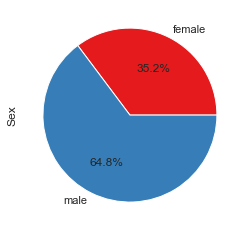

In [19]:
sexes = train_c.groupby(['Sex'])['Sex'].count()
sexes.plot.pie(autopct="%.1f%%")

Info:  
As we can see above 35% of the passengers were women and **74%** of them survived.  
Only **19% of the men** survived.  
So there is a higher chance to survive for **women**.

Let's check this hypothesis via inferential statistics:

In [20]:
x1= train_encoded['Sex']
y = train_encoded['Survived']

In [21]:
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
results_log = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5


In [22]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                  0.2266
Time:                        16:33:33   Log-Likelihood:                -458.90
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.020e-60
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0566      0.129      8.191      0.000       0.804       1.309
Sex           -2.5137      0.167    -15.036      0.000      -2.841      -2.186
==============================================================================
"""

In [23]:
show_table_acc(results_log.pred_table())

          Predicted 0  Predicted 1
Actual 0        468.0         81.0
Actual 1        109.0        233.0
Accuracy:  0.79


The p-value shows that the hypothesis holds.  
The Pseudo R-squared isn't very high yet, but that was supposed as wie just regard one feature.  
A model based on these parameters would get an accuracy of 79% on the training set.

**2. Feature: Pclass**

<AxesSubplot:xlabel='Pclass', ylabel='count'>

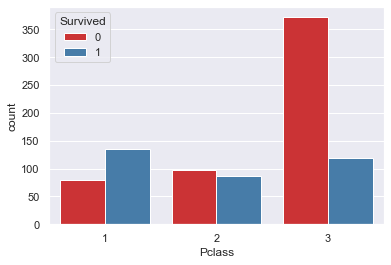

In [24]:
sns.countplot(data=train_c, x='Pclass', hue='Survived')

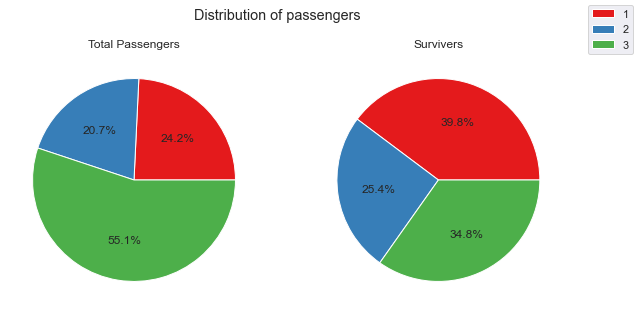

In [25]:
classes_tot = train_c.groupby(['Pclass'])['Pclass'].count()
classes_sur = train_c[train_c['Survived']==1].groupby(['Pclass'])['Pclass'].count()
figure, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.pie(classes_tot, autopct="%.1f%%")
ax1.set_title("Total Passengers")
ax2.pie(classes_sur, autopct="%.1f%%")
ax2.set_title("Survivers")
figure.legend([1,2,3])
figure.suptitle('Distribution of passengers')
plt.show()

Most of the passengers are from Pclass 3, followed by Pclass 1 and Pclass 2.  
Most of the survivors are from Pclass 1, followed by Plass 3 and Pclass 2.

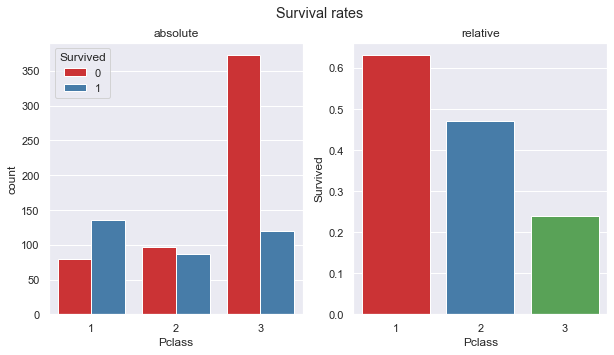

   Pclass  Survived
0       1      0.63
1       2      0.47
2       3      0.24


In [26]:
surv_rates = train_c.groupby(['Pclass'])['Survived'].mean().round(2).to_frame().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Survival rates')

sns.countplot(ax=axes[0], data=train_c, x='Pclass', hue='Survived')
axes[0].set_title('absolute')

sns.barplot(ax=axes[1], data=surv_rates, x = 'Pclass', y = 'Survived')
axes[1].set_title('relative')
plt.show()
print(surv_rates)

Even if Pclass 3 has the second most survivors, the chance to survive decreases from over 63% in class 1 to 47% in Pclass 2 and just 24% in Pclass 3.  
Thus, we have a hypothesis for testing.

In [27]:
x1= train_encoded['Pclass']
y = train_encoded['Survived']

In [28]:
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
results_log = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.608531
         Iterations 5


In [29]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                 0.08617
Time:                        16:33:38   Log-Likelihood:                -542.20
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 4.885e-24
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4468      0.207      6.975      0.000       1.040       1.853
Pclass        -0.8501      0.087     -9.755      0.000      -1.021      -0.679
==============================================================================
"""

In [30]:
show_table_acc(results_log.pred_table())

          Predicted 0  Predicted 1
Actual 0        469.0         80.0
Actual 1        206.0        136.0
Accuracy:  0.68


The p-value shows that this hypothesis also holds.   
A model based on these parameters would get an accuracy of 68% on the training set.

**3.Feature: Fare**

In [31]:
train_c['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [32]:
train_c.groupby(['Pclass'])['Fare'].mean().round(2)

Pclass
1    84.15
2    20.66
3    13.68
Name: Fare, dtype: float64

<AxesSubplot:xlabel='Fare', ylabel='Count'>

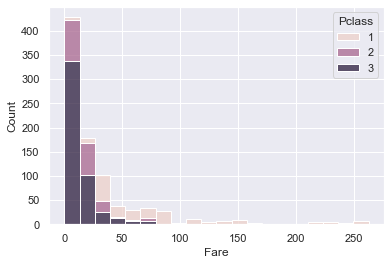

In [33]:
sns.histplot(data=train_c[train_c['Fare']<300],x='Fare',bins=20,multiple="stack" ,hue='Pclass')

It is suspicious that there are tickets with 0 value.
By intuition the fare should be higher in the 1st class than in the 2nd or 3rd class.  
In the average that is correct, but specific tickets vary from that.

In [34]:
train_c[train_c['Fare']==0]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
179,0,3,male,36.0,0,0,0.0,S
263,0,1,male,40.0,0,0,0.0,S
271,1,3,male,25.0,0,0,0.0,S
277,0,2,male,NaN,0,0,0.0,S
302,0,3,male,19.0,0,0,0.0,S
413,0,2,male,NaN,0,0,0.0,S
466,0,2,male,NaN,0,0,0.0,S
481,0,2,male,NaN,0,0,0.0,S
597,0,3,male,49.0,0,0,0.0,S
633,0,1,male,NaN,0,0,0.0,S


It is likely that these be bad data as some do not contain age and all have zero-values for SibSp and Parch.
We delete them.

In [35]:
train_c = train_c[train_c['Fare']!=0]
train_encoded = train_encoded[train_encoded['Fare']!=0]

Text(0.5, 1.0, 'log regression')

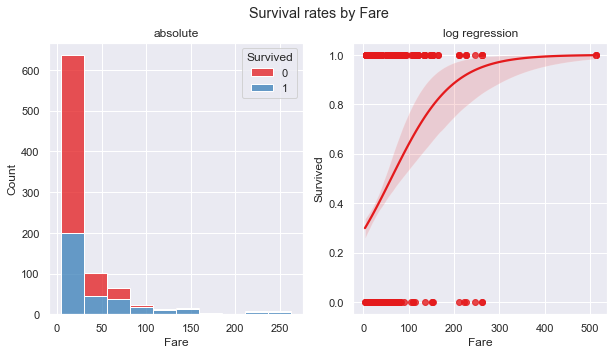

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Survival rates by Fare')

sns.histplot(ax=axes[0], data=train_c[train_c['Fare']<300],x='Fare',bins=10,multiple="stack" ,hue='Survived')
axes[0].set_title('absolute')

sns.regplot(ax=axes[1], data=train_c, x='Fare', y='Survived', logistic=True)
axes[1].set_title('log regression')

The graphics shows a higher chance of survival if the fare is higher.

In [37]:
x1= train_c['Fare']
y = train_c['Survived']

In [38]:
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
results_log = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.631113
         Iterations 6


In [39]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  876
Model:                          Logit   Df Residuals:                      874
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                 0.05581
Time:                        16:33:48   Log-Likelihood:                -552.85
converged:                       True   LL-Null:                       -585.54
Covariance Type:            nonrobust   LLR p-value:                 6.232e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9117      0.096     -9.514      0.000      -1.099      -0.724
Fare           0.0147      0.002      6.643      0.000       0.010       0.019
==============================================================================
"""

Log-likelihood, LL-Null and LLR p-Value are still good and the hypothesis can be confirmed.

In [40]:
show_table_acc(results_log.pred_table())

          Predicted 0  Predicted 1
Actual 0        497.0         38.0
Actual 1        259.0         82.0
Accuracy:  0.66


### Dependencies between the Top 3 variables  
We need to check this to avoid issues like e.g. multicollinearity.  
Also we want to get deeper insights on our Top-features.

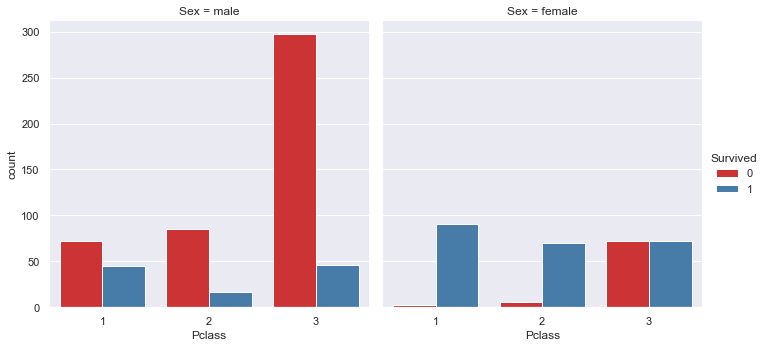

In [41]:
sns.catplot(data=train_c, x='Pclass', hue='Survived', kind = 'count', col='Sex')

We see that nearly all women in Pclass1 survived. In Pclass 3 it's around 50% which will probably lead to most errors in our prediction model as long as we don't have a third feature to sharpen that view.

In [42]:
class_sex_1 = train_c.groupby(['Pclass','Sex','Survived'])['Survived'].count()
gender = ['female','male']
print("Survival rates by class/gender")
for i in range(1,4):
    for x in gender:
        print('Class ' + str(i) +" "+ x + ": " + str(round((class_sex_1[i][x][1])/class_sex_1[i][x].sum()*100,2))+"%")

Survival rates by class/gender
Class 1 female: 96.81%
Class 1 male: 38.46%
Class 2 female: 92.11%
Class 2 male: 16.67%
Class 3 female: 50.0%
Class 3 male: 13.41%


In numbers it is also very obvious, that the chance to survive for women in Pclass 1 & 2 is very high. Even the baddest chance for women in Pclass 3 is still higher as all the chances for men.  
Still, as we face a binary binary classification problem, we are not adding value for the prediction model, as women would be classified as 'survived' (all at least 50%) and men would be classified as 'not survived' (all below 50%)

In [43]:
train_c.groupby(['Sex','Pclass','Survived'])['Fare'].mean().round(2)

Sex     Pclass  Survived
female  1       0           110.60
                1           105.98
        2       0            18.25
                1            22.29
        3       0            19.77
                1            12.46
male    1       0            67.26
                1            74.64
        2       0            20.86
                1            21.10
        3       0            12.33
                1            15.92
Name: Fare, dtype: float64

Adding the fare feature wouldn't change anything. We would still guess women survived and men didn't.
In a log reg-model the fare will probably have non or low significance as the conditional probability will not change by including the fare.

In [44]:
x1= train_encoded[['Sex', 'Pclass', 'Fare']]
y = train_encoded['Survived']

In [45]:
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
results_log = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.464114
         Iterations 6


In [46]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  876
Model:                          Logit   Df Residuals:                      872
Method:                           MLE   Df Model:                            3
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                  0.3057
Time:                        16:33:50   Log-Likelihood:                -406.56
converged:                       True   LL-Null:                       -585.54
Covariance Type:            nonrobust   LLR p-value:                 2.842e-77
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2989      0.370      8.909      0.000       2.573       4.025
Sex           -2.6162      0.186    -14.082      0.000      -2.980      -2.252
Pclass        -0.9706      0.124     -7.825      0.000      -1.214      -0.727
Fare           0.0007      0.002      0.348      0.728      -0.003       0.005
==============================================================================
"""

Indeed, the Fare is not significant. Still we have the problem that the probability to survive based on the conditions sex and Pclass don't vary from that one base only on the condition sex.
This might be a set-back regarding the goal of this attempt to be *quick* and not getting *too deep*.
Still it proves that you have to be careful when finding the features for a good model, even for simple ones.

##  Finding another variable

The correlation was not great for the other variables. Let's have a look on the graphs of the variables that might not need any feature engineering. 

In [47]:
train_c.groupby(['Sex','Survived']).mean()

Pclass        Age     SibSp     Parch       Fare
Sex    Survived                                                    
female 0         2.851852  25.046875  1.209877  1.037037  23.024385
       1         1.918455  28.847716  0.515021  0.515021  51.938573
male   0         2.495595  31.529661  0.453744  0.213656  22.638204
       1         2.009259  27.300761  0.388889  0.361111  41.199461

SibSp and Parch might be good features

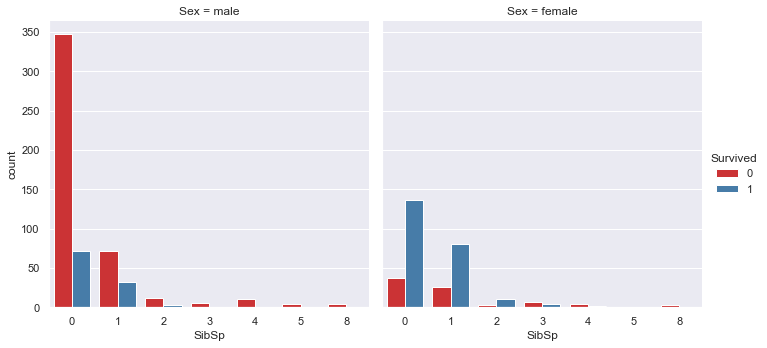

In [48]:
sns.catplot(data=train_c, x='SibSp', hue='Survived', kind = 'count', col='Sex')

The number of siblings might make a difference as we can see above.  
A look at the numbers should enlighten us further.

In [49]:
SibSp_sex = train_c.groupby(['SibSp','Sex','Survived'])['Survived'].count()
print("Survival rates by SibSp/gender")
for x in gender:
    for i in range(0,9):
        try:
            print('SibSp ' + str(i) +" "+ x + ": " + str(round((SibSp_sex[i][x][1])/SibSp_sex[i][x].sum()*100,2))+"% of total: " +str(round(SibSp_sex[i][x].sum(),2)) )
        except:
            print('SibSp ' + str(i) +" "+ x + ": " + str(0) +"%")

Survival rates by SibSp/gender
SibSp 0 female: 78.74% of total: 174
SibSp 1 female: 75.47% of total: 106
SibSp 2 female: 76.92% of total: 13
SibSp 3 female: 36.36% of total: 11
SibSp 4 female: 33.33% of total: 6
SibSp 5 female: 0%
SibSp 6 female: 0%
SibSp 7 female: 0%
SibSp 8 female: 0%
SibSp 0 male: 17.18% of total: 419
SibSp 1 male: 31.07% of total: 103
SibSp 2 male: 20.0% of total: 15
SibSp 3 male: 0%
SibSp 4 male: 8.33% of total: 12
SibSp 5 male: 0%
SibSp 6 male: 0%
SibSp 7 male: 0%
SibSp 8 male: 0%


Nothing new for men, but for women the chances to survive falls from above 75% to below 37% when you have at least 3 SibSp. 

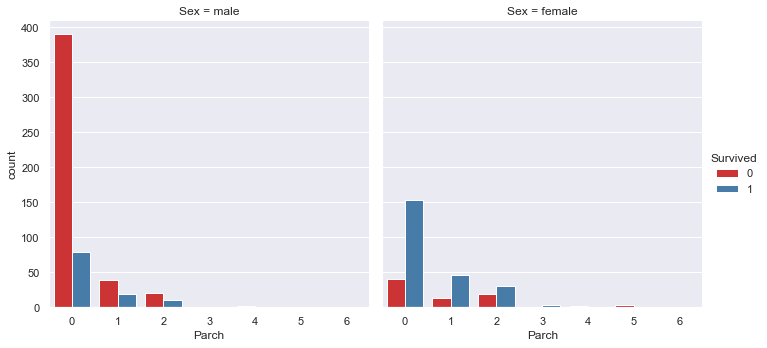

In [50]:
sns.catplot(data=train_c, x='Parch', hue='Survived', kind = 'count', col='Sex')

The graphics don't show interesting things for the Parch feature. Let's look at the numbers.

In [51]:
Parch_sex = train_c.groupby(['Parch','Sex','Survived'])['Survived'].count()
print("Survival rates by Parch/gender")
for x in gender:
    for i in range(0,7):
        try:
            print('Parch ' + str(i) +" "+ x + ": " + str(round((Parch_sex[i][x][1])/Parch_sex[i][x].sum()*100,2))+"% of total: " + str(round(Parch_sex[i][x].sum(),2)) )
        except:
            print('Parch ' + str(i) +" "+ x + ": " + str(0) +"%")

Survival rates by Parch/gender
Parch 0 female: 78.87% of total: 194
Parch 1 female: 76.67% of total: 60
Parch 2 female: 61.22% of total: 49
Parch 3 female: 75.0% of total: 4
Parch 4 female: 0%
Parch 5 female: 25.0% of total: 4
Parch 6 female: 0%
Parch 0 male: 16.84% of total: 469
Parch 1 male: 32.76% of total: 58
Parch 2 male: 32.26% of total: 31
Parch 3 male: 0%
Parch 4 male: 0%
Parch 5 male: 0%
Parch 6 male: 0%


At Parch size 4 the chances drop for women.
Let's try to combine these two features.

In [52]:
train_c['Family_Size'] = train_c['Parch'] + train_c['SibSp']
train_encoded['Family_Size'] = train_encoded['Parch'] + train_encoded['SibSp']

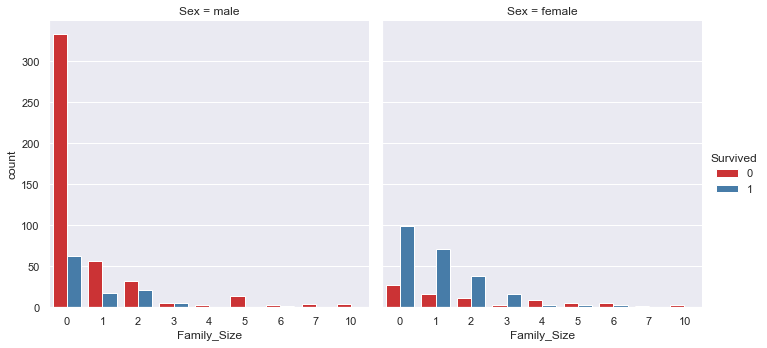

In [53]:
sns.catplot(data=train_c, x='Family_Size', hue='Survived', kind = 'count', col='Sex')

In [54]:
Family_Size_sex = train_c.groupby(['Family_Size','Sex','Survived'])['Survived'].count()
Family_Size_Pclass = train_c.groupby(['Family_Size','Pclass','Survived'])['Survived'].count()
print("Survival rates by Family_Size/gender")
for x in gender:
    for i in range(0,11):
        try:
            print('Family Size ' + str(i) +" "+ x + ": " + str(round((Family_Size_sex[i][x][1])/Family_Size_sex[i][x].sum()*100,2))+"%")
        except:
            print('Family Size ' + str(i) +" "+ x + ": " + str(0) +"%")

Survival rates by Family_Size/gender
Family Size 0 female: 78.57%
Family Size 1 female: 81.61%
Family Size 2 female: 77.55%
Family Size 3 female: 84.21%
Family Size 4 female: 25.0%
Family Size 5 female: 37.5%
Family Size 6 female: 37.5%
Family Size 7 female: 0%
Family Size 8 female: 0%
Family Size 9 female: 0%
Family Size 10 female: 0%
Family Size 0 male: 15.91%
Family Size 1 male: 24.32%
Family Size 2 male: 39.62%
Family Size 3 male: 50.0%
Family Size 4 male: 0%
Family Size 5 male: 0%
Family Size 6 male: 25.0%
Family Size 7 male: 0%
Family Size 8 male: 0%
Family Size 9 male: 0%
Family Size 10 male: 0%


Family size of three had the best chances to survive. Even 50% of the male survived. 

In [55]:
Family_Size_Pclass

Family_Size  Pclass  Survived
0            1       0            46
                     1            58
             2       0            62
                     1            36
             3       0           252
                     1            68
1            1       0            19
                     1            51
             2       0            16
                     1            18
             3       0            37
                     1            20
2            1       0             6
                     1            18
             2       0            10
                     1            21
             3       0            27
                     1            20
3            1       0             2
                     1             5
             2       0             3
                     1            10
             3       0             3
                     1             6
4            1       1             2
             2       1             1
        

Working through above table above might get a little bit to deep for this approach but it shows two important things:  
  
1. The combination of Family size with our previous features adds benefit as the outcome changes.  
2. There might be the risk of overfitting as the samples are partially becoming very small.   
      
Also the next table shows the same.

In [56]:
print("Survival rates by Family_Size/class")
for x in train_c['Pclass'].unique().tolist():
    for i in range(0,11):
        try:
            print('Family Size ' + str(i) +" "+ str(x) + ": " + str(round((Family_Size_Pclass[i][x][1])/Family_Size_Pclass[i][x].sum()*100,2))+"%")
        except:
            print('Family Size ' + str(i) +" "+ str(x) + ": " + str(0) +"%")

Survival rates by Family_Size/class
Family Size 0 3: 21.25%
Family Size 1 3: 35.09%
Family Size 2 3: 42.55%
Family Size 3 3: 66.67%
Family Size 4 3: 0%
Family Size 5 3: 0%
Family Size 6 3: 33.33%
Family Size 7 3: 0%
Family Size 8 3: 0%
Family Size 9 3: 0%
Family Size 10 3: 0%
Family Size 0 1: 55.77%
Family Size 1 1: 72.86%
Family Size 2 1: 75.0%
Family Size 3 1: 71.43%
Family Size 4 1: 100.0%
Family Size 5 1: 50.0%
Family Size 6 1: 0%
Family Size 7 1: 0%
Family Size 8 1: 0%
Family Size 9 1: 0%
Family Size 10 1: 0%
Family Size 0 2: 36.73%
Family Size 1 2: 52.94%
Family Size 2 2: 67.74%
Family Size 3 2: 76.92%
Family Size 4 2: 100.0%
Family Size 5 2: 100.0%
Family Size 6 2: 0%
Family Size 7 2: 0%
Family Size 8 2: 0%
Family Size 9 2: 0%
Family Size 10 2: 0%


We finally found our 3 features for our prediction model.  
Due to the different behaviour between it is likely that a Decision Tree might come to the best outcome.

### 4. Step: Train models on best variables 

Now we will build different models and check how good they predict who will survive:  
    0. Baseline Model   
    1. Naive Bayes  
    2. Logistic Regression   
    3. SVM Classifier   
    4. KNN  
    5. Decision Tree  
    6. (Random) Forest  
    7. XGBoost

#### Preparation

In [57]:
features = ['Sex', 'Pclass', 'Family_Size']

In [58]:
train = train_encoded[features]
target = train_encoded['Survived']

In [59]:
train_encoded.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_Size
0,0,3,1,22.0,1,0,7.2500,S,1
1,1,1,0,38.0,1,0,71.2833,C,1
2,1,3,0,26.0,0,0,7.9250,S,0
3,1,1,0,35.0,1,0,53.1000,S,1
4,0,3,1,35.0,0,0,8.0500,S,0


In [60]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [61]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.20, random_state = 1337)

In [62]:
models = [
    { "model": "Baseline" },
    { "model": "Naive Bayes" },
    { "model": "Logistic Regression" },
    { "model": "SVC" },
    { "model": "KNN" },
    { "model": "Decision Tree" },
    { "model": "Random Forest" },
    { "model": "XGBoost" }
    ]
scores_dict = {model["model"]: [] for model in models}

In [63]:
scores_dict

{'Baseline': [],
 'Naive Bayes': [],
 'Logistic Regression': [],
 'SVC': [],
 'KNN': [],
 'Decision Tree': [],
 'Random Forest': [],
 'XGBoost': []}

#### Start modeling and testing

0. Baseline Model  

In [64]:
y_base_test = X_test['Sex']
y_base_train = X_train['Sex']

In [65]:
y_base_test=(y_base_test*-1)+1
y_base_train=(y_base_train*-1)+1

In [66]:
input = confusion_matrix(y_train, y_base_train)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0          363           65
Actual 1           93          179
Accuracy:  0.77


In [67]:
input = confusion_matrix(y_test, y_base_test)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0           91           16
Actual 1           15           54
Accuracy:  0.82


In [68]:
scores_dict['Baseline'].append(accuracy_score(y_test, y_base_test))

1. Naive Bayes

In [69]:
from sklearn.naive_bayes import GaussianNB

In [70]:
model1 = GaussianNB()
model1.fit(X_train, y_train)

GaussianNB()

In [71]:
y_pred1 = model1.predict(X_test)
y_pred_train1 = model1.predict(X_train)

In [72]:
input = confusion_matrix(y_train, y_pred_train1)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0          324          104
Actual 1           57          215
Accuracy:  0.77


In [73]:
input = confusion_matrix(y_test, y_pred1)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0           84           23
Actual 1           13           56
Accuracy:  0.8


In [74]:
scores_dict['Naive Bayes'].append(accuracy_score(y_test, y_pred1))

2. Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression

In [76]:
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression()

In [77]:
y_pred2 = model2.predict(X_test)
y_pred_train2 = model2.predict(X_train)

In [78]:
input = confusion_matrix(y_train, y_pred_train2)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0          374           54
Actual 1           95          177
Accuracy:  0.79


In [79]:
input = confusion_matrix(y_test, y_pred2)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0           95           12
Actual 1           16           53
Accuracy:  0.84


In [80]:
scores_dict['Logistic Regression'].append(accuracy_score(y_test, y_pred2))

3. SVM Classifier (SVC)

In [81]:
from sklearn.svm import SVC

In [82]:
param_grid = {
    "kernel":['rbf', 'linear','sigmoid'],
    "C" : [0.1, 0.5, 1, 5, 10,12, 15], 
    "gamma" : [0.01, 0.05, 0.1, 0.5, 1,5,10]}

In [83]:
model3 = GridSearchCV(SVC(), param_grid = param_grid, cv = RepeatedKFold(n_splits = 10,n_repeats=20), n_jobs = 10,verbose = 2)
model3.fit(X_train, y_train)

Fitting 200 folds for each of 147 candidates, totalling 29400 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=20, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=10,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 12, 15],
                         'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             verbose=2)

In [84]:
print(model3.best_params_)

{'C': 0.5, 'gamma': 0.05, 'kernel': 'rbf'}


In [85]:
y_pred3 = model3.predict(X_test)
y_pred_train3 = model3.predict(X_train)

In [86]:
input = confusion_matrix(y_train, y_pred_train3)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0          380           48
Actual 1           95          177
Accuracy:  0.8


In [87]:
input = confusion_matrix(y_test, y_pred3)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0           98            9
Actual 1           17           52
Accuracy:  0.85


In [88]:
scores_dict['SVC'].append(accuracy_score(y_test, y_pred3))

4. KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier

In [90]:
param_grid = dict(n_neighbors=list(range(1, 31)), p =[1,2], leaf_size = [15,20,25,30,35,40])

In [91]:
model4 = GridSearchCV(estimator= KNeighborsClassifier(), param_grid = param_grid, cv=RepeatedKFold(), scoring='accuracy', n_jobs=10)
model4.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid={'leaf_size': [15, 20, 25, 30, 35, 40],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'p': [1, 2]},
             scoring='accuracy')

In [92]:
print(model4.best_params_)

{'leaf_size': 15, 'n_neighbors': 22, 'p': 2}


In [93]:
y_pred4 = model4.predict(X_test)
y_pred_train4 = model4.predict(X_train)

In [94]:
input = confusion_matrix(y_train, y_pred_train4)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0          385           43
Actual 1          104          168
Accuracy:  0.79


In [95]:
input = confusion_matrix(y_test, y_pred4)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0           99            8
Actual 1           20           49
Accuracy:  0.84


In [96]:
scores_dict['KNN'].append(accuracy_score(y_test, y_pred4))

5. Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier

In [98]:
param_grid = dict(max_depth=list(range(1,10)),criterion=['gini','entropy'],min_samples_leaf = list(range(1,20)) )

In [99]:
model5 = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv= RepeatedKFold(),n_jobs=10, verbose = 3)
model5.fit(X_train, y_train)

Fitting 50 folds for each of 342 candidates, totalling 17100 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=DecisionTreeClassifier(), n_jobs=10,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             verbose=3)

In [100]:
model5.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 12}

In [101]:
y_pred5 = model5.predict(X_test)
y_pred_train5 = model5.predict(X_train)

In [102]:
input = confusion_matrix(y_train, y_pred_train5)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0          380           48
Actual 1           95          177
Accuracy:  0.8


In [103]:
input = confusion_matrix(y_test, y_pred5)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0           98            9
Actual 1           16           53
Accuracy:  0.86


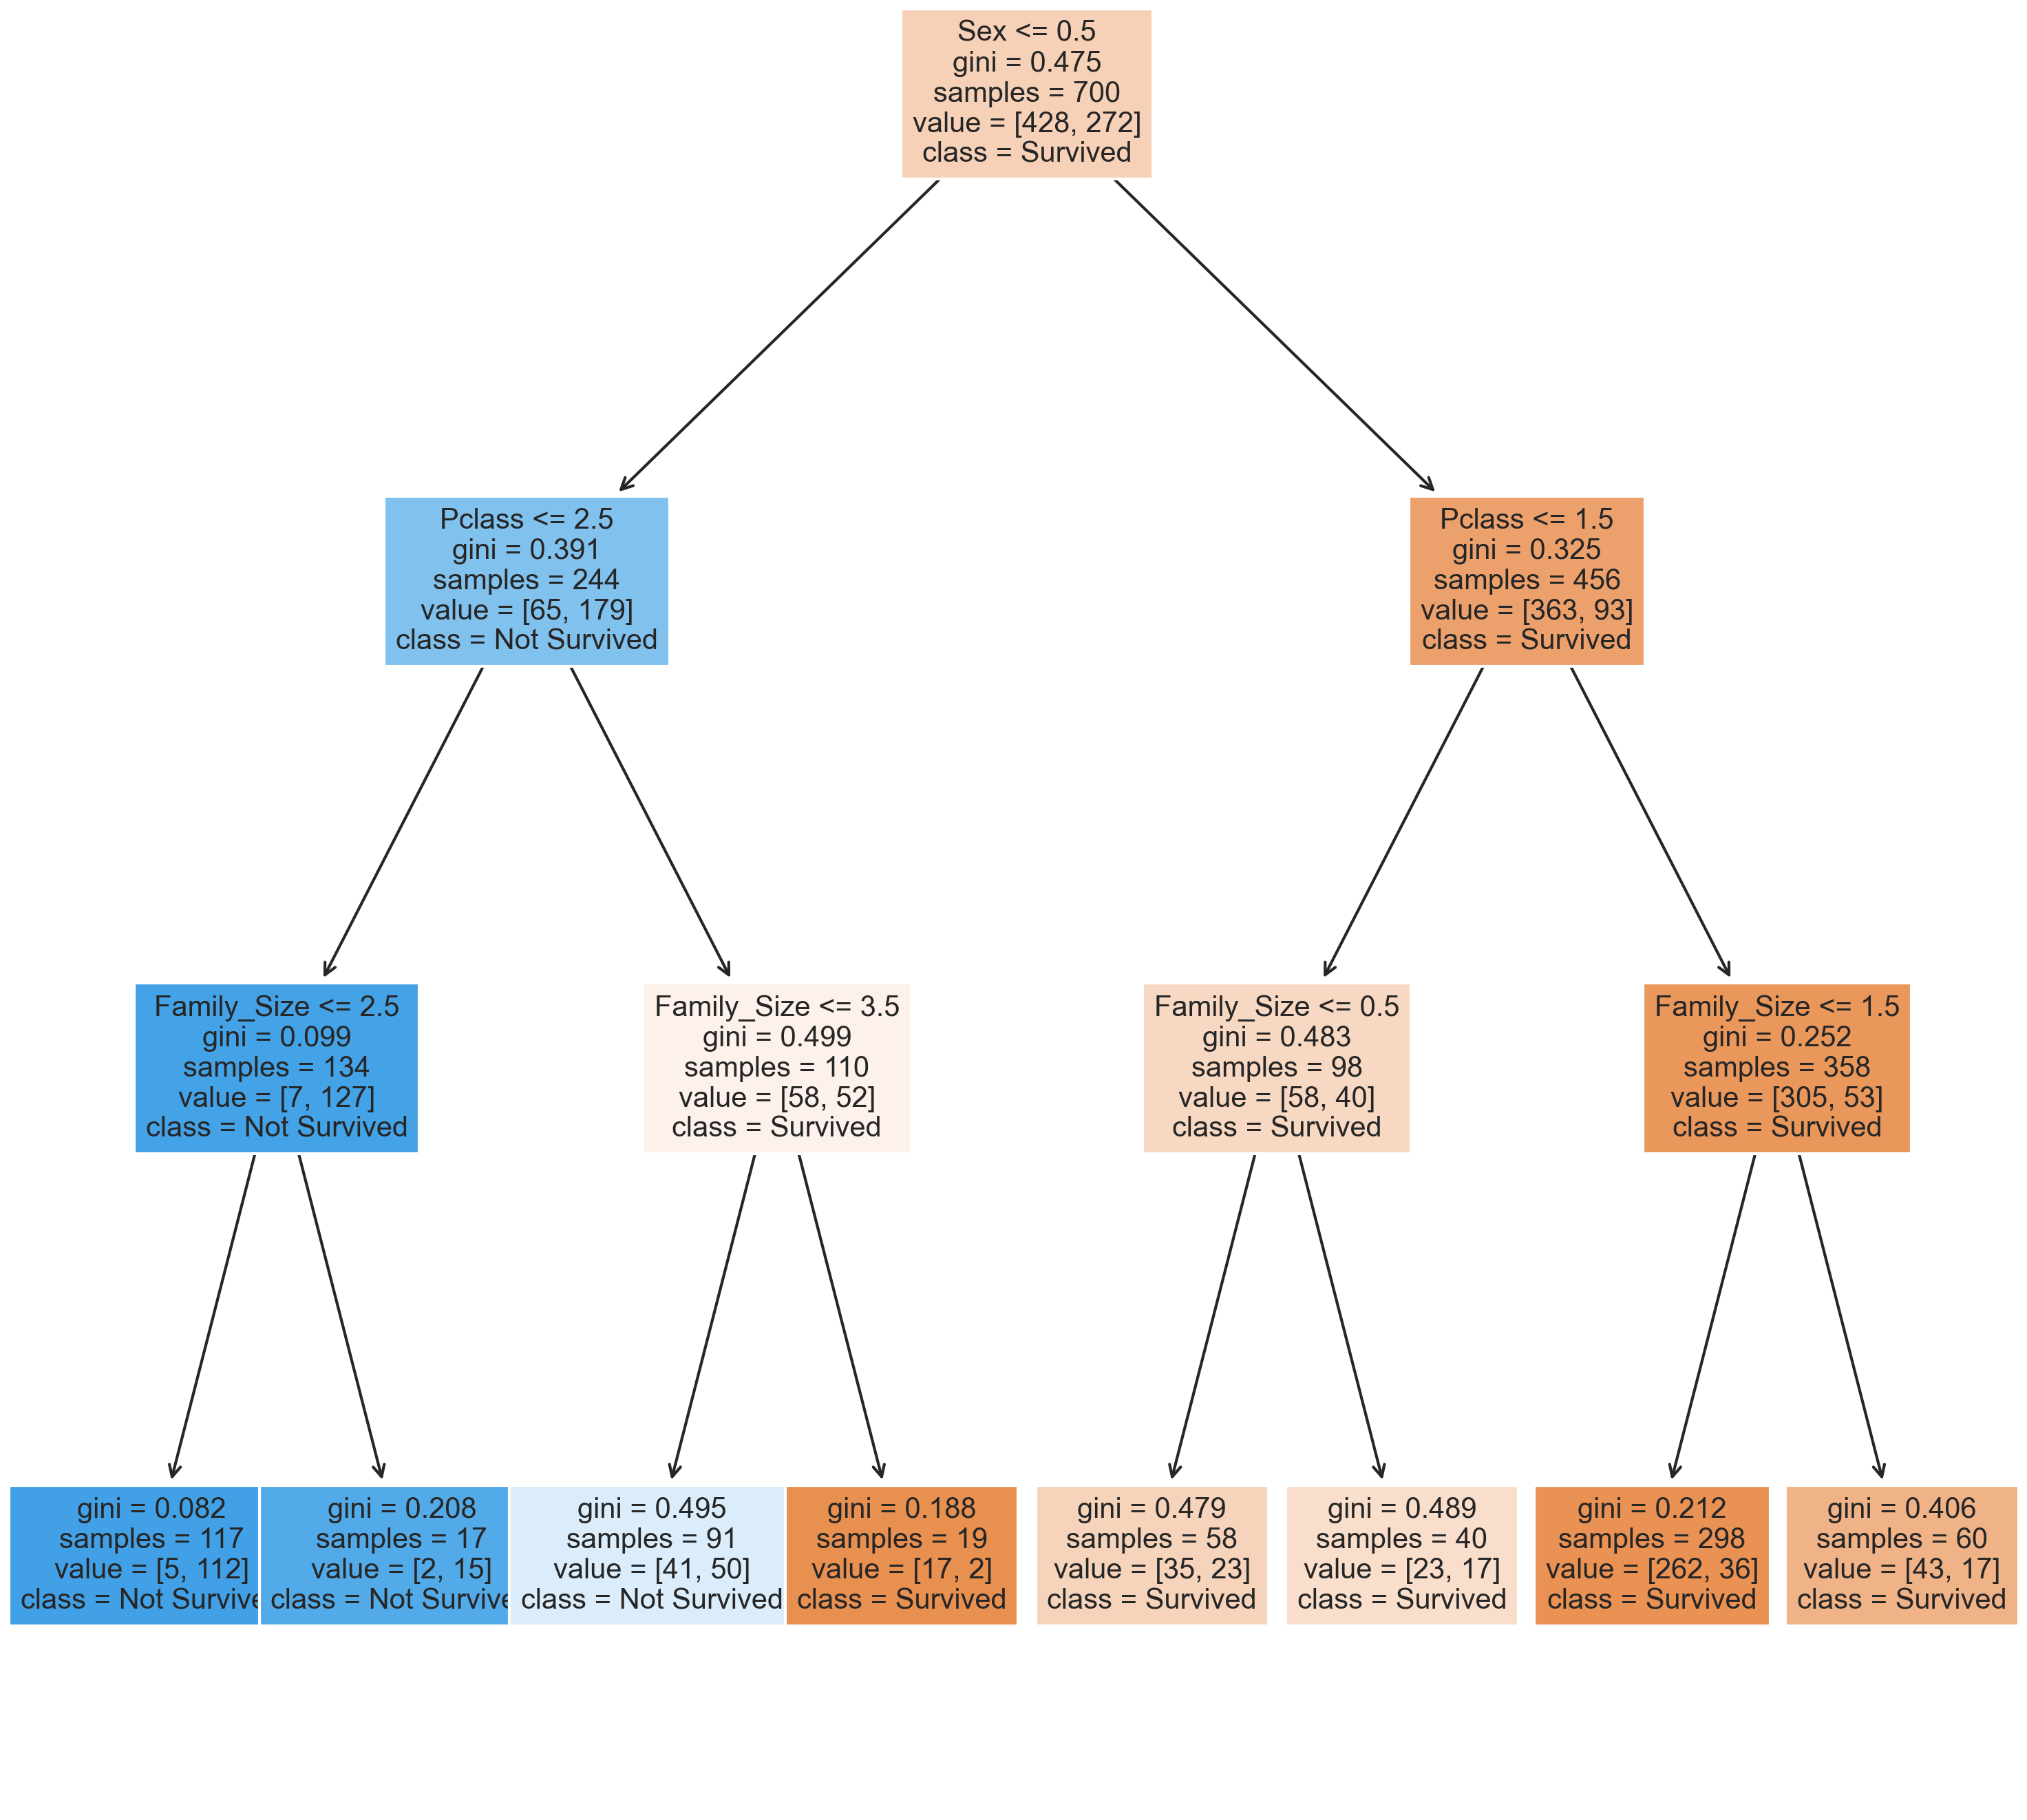

In [104]:
from sklearn.tree import plot_tree
plt.figure(figsize=(3,3), dpi=300)
plot_tree(model5.best_estimator_, feature_names = train.columns,class_names = ['Survived','Not Survived'], filled = True, fontsize=10)

plt.show()

In [105]:
x = 0
for f in features:
    print(f+":"+str(model5.best_estimator_.feature_importances_[x]))
    x+=1

Sex:0.6562174344580717
Pclass:0.27722106189206
Family_Size:0.06656150364986843


In [106]:
scores_dict['Decision Tree'].append(accuracy_score(y_test, y_pred5))

6. Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3, 4, 5, 6, 7],
    'criterion' :['gini', 'entropy']
}

In [109]:
model6 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= RepeatedKFold(),n_jobs=10,verbose = 3)
model6.fit(X_train, y_train)

Fitting 50 folds for each of 210 candidates, totalling 10500 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=RandomForestClassifier(), n_jobs=10,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=3)

In [110]:
model6.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [111]:
x = 0
for f in features:
    print(f+":"+str(model6.best_estimator_.feature_importances_[x]))
    x+=1

Sex:0.5416644956453046
Pclass:0.31524123251951736
Family_Size:0.14309427183517812


In [112]:
y_pred6 = model6.predict(X_test)
y_pred_train6 = model6.predict(X_train)

In [113]:
input = confusion_matrix(y_train, y_pred_train6)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0          380           48
Actual 1           93          179
Accuracy:  0.8


In [114]:
input = confusion_matrix(y_test, y_pred6)
show_table_acc(input)

          Predicted 0  Predicted 1
Actual 0           98            9
Actual 1           15           54
Accuracy:  0.86


In [115]:
scores_dict['Random Forest'].append(accuracy_score(y_test, y_pred6))

7. xgboost

In [116]:
from xgboost import XGBClassifier

In [117]:
param_grid = { 
    'n_estimators': [50, 100, 250, 500],
#    'colsample_bytree': [0.2, 0.5, 0.7, 1],
    'max_depth': [5, 15, 25, None],
#    'reg_alpha': [0, 0.5, 1],
#    'reg_lambda': [1, 1.5, 2],
#    'subsample': [0.5,0.7,.9],
    'learning_rate':[.01,0.1,0.5, 0.9],
    'gamma':[0,.01,.1,1,10],
    'min_child_weight':[0,.01,0.1,1,10],
#    'sampling_method': ['uniform', 'gradient_based']    
}

In [118]:
model7 = GridSearchCV(XGBClassifier(),param_grid=param_grid, cv=RepeatedKFold(), verbose=10, n_jobs=-1)
model7.fit(X_train,y_train)

Fitting 50 folds for each of 1600 candidates, totalling 80000 fits
[18:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missin...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
              

In [119]:
model7.best_params_

{'gamma': 1,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 100}

In [120]:
y_pred7 = model7.predict(X_test)
y_pred_train7 = model7.predict(X_train)

In [121]:
print("Accuracy Test: ", accuracy_score(y_test, y_pred7))
print("Accuracy Train: ", accuracy_score(y_train, y_pred_train7))

Accuracy Test:  0.8579545454545454
Accuracy Train:  0.7957142857142857


In [122]:
cm_df = pd.DataFrame(confusion_matrix(y_train, y_pred_train7))
cm_df.columns = ['Predicted 0','Predicted 1']
cm_df = cm_df.rename(index={0:'Actual 0',1:'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,380,48
Actual 1,95,177


In [123]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred7))
cm_df.columns = ['Predicted 0','Predicted 1']
cm_df = cm_df.rename(index={0:'Actual 0',1:'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,98,9
Actual 1,16,53


In [124]:
scores_dict['XGBoost'].append(accuracy_score(y_test, y_pred7))

In [125]:
pd.DataFrame.from_dict(scores_dict, orient='index', columns=['test accuracy']).sort_values(by='test accuracy', ascending=False)

,test accuracy
Random Forest,0.863636
Decision Tree,0.857955
XGBoost,0.857955
SVC,0.852273
Logistic Regression,0.840909
KNN,0.840909
Baseline,0.823864
Naive Bayes,0.795455


The best fit on the validation set has the Random Forest model.   
The Decision Tree would be the best model to explain the prediction to someone else.  
The Tree showed exactly our the explanation of the EDA.  
For the first submission we submit the Random Forest model. As it has the risk of overfitting we should also consider the other models.   
XGBoost and SVC aren't that far behind. 

In [138]:
test['Family_Size'] = test['Parch'] + test['SibSp']
test['Sex'] = label.fit_transform(test['Sex'])
test = test[features]

In [127]:
final = model5.predict(test)

In [129]:
submission_sample2 = submission_sample.copy()

In [130]:
submission_sample2['Survived'] = final

In [143]:
submission_sample2

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [142]:
submission_sample2.set_index('PassengerId').to_csv('Titanic_Submission_fast_approach_20210822.csv')